In [1]:
import ast
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings

from itertools import product
from joblib import Parallel, delayed

from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from stepmix.bootstrap import blrt_sweep
from stepmix.stepmix import StepMix
from tqdm import tqdm

from src.model_fit import do_StepMix
from src.model_select import elbow_method, lrt, blrt_sweep_custom

In [2]:
CVI = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
max_threads = 8

# Preparation
## Data

In [3]:
var_list = [
    'clseusa', 'ambornin', 'amcit', 'amlived', 'amenglsh', 'amchrstn',
    'amgovt', 'amfeel', 'amcitizn', 'amshamed', 'belikeus', 'ambetter',
    'ifwrong', 'proudsss', 'proudgrp', 'proudpol', 'prouddem', 'proudeco',
    'proudspt', 'proudart', 'proudhis', 'proudmil', 'proudsci']

var_list_f = [var + "_f" for var in var_list]
var_list_n = [var + "_n" for var in var_list]

ctrl_list = [
    'party_f', 'race_f', 'educ_f', 'region_f', 'reltrad_f', 'religstr_f', 
    'born_usa_f', 'sex_f', 'age_n', 'lnrealinc2004_n', 'age_n', 'lnrealinc2004_n']

In [4]:
data2004 = pd.read_parquet(f"data/data2004_replic.parquet")
data2004_ni = pd.read_parquet(f"data/data2004_replic_ni.parquet")

# Datasets with numeric outcomes
data_n = data2004[var_list_n]
data_n = StandardScaler().fit_transform(data_n)
data_n = pd.DataFrame(data_n)

data_ni_n = data2004[var_list_n]
data_ni_n = StandardScaler().fit_transform(data_ni_n)
data_ni_n = pd.DataFrame(data_ni_n)

# Dataset with categorical outcomes and reindexing to 0 (as expected by StepMix)
data_f = data2004[var_list_n] - 1
data_ni_f = data2004_ni[var_list_n] - 1

# Dataset with controls (same as the authors)
controls = data2004[ctrl_list]
controls_dum = pd.get_dummies(controls)

# Sample weights
weights = data2004['wgt']

# Replication

The authors perform LCA with 1 to 8 classes with missing data, sociodemographic covariates, and sample weights. Do we get similar results with the [StepMix](https://stepmix.readthedocs.io/en/latest/api.html#stepmix) package?

In [5]:
results = Parallel(n_jobs=max_threads)(
    delayed(do_StepMix)(
        data = data_ni_f,
        controls = controls_dum,
        n = n_clust,
        msrt = 'categorical_nan',
        covar = 'with',
        weights = weights)
    for n_clust in tqdm(range(1,9), desc='Fitting latent models'))

replic_LCA = pd.DataFrame(results).drop(columns = ['model', 'params', 'silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn'])

Fitting latent models: 100%|██████████| 8/8 [00:00<00:00, 156.68it/s]


In [6]:
replic_LCA.style

,n_clust,min_clust_size,max_clust_size,aic,bic,sabic,relative_entropy,classif_error,df,LL
0,1,1080,1080,45279.221617,45623.167043,45885.954415,nan,0.000000,69.000000,-20.898714
1,2,415,665,42448.454766,43320.780122,43987.269832,0.860534,0.039776,175.000000,-19.490025
2,3,222,432,41548.533566,42949.238852,44019.430900,0.851409,0.068046,281.000000,-18.975247
3,4,199,395,40984.770824,42913.856040,44387.750427,0.870181,0.070356,387.000000,-18.616098
4,5,81,361,40651.040619,43108.505765,44986.102491,0.883073,0.074222,493.000000,-18.363445
5,6,63,312,40557.515439,43543.360515,45824.659580,0.867750,0.093692,599.000000,-18.221998
6,7,42,297,40498.061985,44012.286991,46697.288394,0.877928,0.091310,705.000000,-18.096325
7,8,39,216,40503.925477,44546.530413,47635.234155,0.876253,0.098929,811.000000,-18.000891


## Absolute values

In [7]:
best_aic = replic_LCA.sort_values('aic', ascending=True).iloc[0]
best_bic = replic_LCA.sort_values('bic', ascending=True).iloc[0]
best_sabic = replic_LCA.sort_values('sabic', ascending=True).iloc[0]
best_entropy = replic_LCA.sort_values('relative_entropy', ascending=False).iloc[0]

print(f"Best model according to the min/max rule applied to...")
print(f"- AIC (min) has {best_aic['n_clust']:.0f} clusters")
print(f"- BIC (min) has {best_bic['n_clust']:.0f} clusters")
print(f"- SABIC (min) has {best_sabic['n_clust']:.0f} clusters")
print(f"- Relative entropy (max) has {best_entropy['n_clust']:.0f} clusters")

Best model according to the min/max rule applied to...
- AIC (min) has 7 clusters
- BIC (min) has 4 clusters
- SABIC (min) has 2 clusters
- Relative entropy (max) has 5 clusters


## Elbow method

In [8]:
best_aic = elbow_method(replic_LCA, 'aic')
best_bic = elbow_method(replic_LCA, 'bic')
best_sabic = elbow_method(replic_LCA, 'sabic')
best_entropy = elbow_method(replic_LCA, 'relative_entropy')

print(f"Best model according to the Elbow method applied to...")

if best_aic is None: print("- AIC is None")
else: print(f"- AIC has {best_aic} clusters")

if best_bic is None: print("- BIC is None")
else: print(f"- BIC has {best_bic} clusters")

if best_sabic is None: print("- SABIC is None")
else: print(f"- SABIC has {best_sabic} clusters")
    
if best_entropy is None: print("- Entropy is None")
else: print(f"- Entropy has {best_entropy} clusters")

Best model according to the Elbow method applied to...
- AIC has 3 clusters
- BIC has 2 clusters
- SABIC has 2 clusters
- Entropy has 3 clusters


## LRT
*LRT - not advisable for comparing models with $k$ and $k-1$ classes as the resulting test statistics does not follow the $\chi^2$ distribution under the null hypothesis. The implementation below compare models to the 1-class model, which is sometimes recommended, without a formal justification.*

In [9]:
LRT = lrt(replic_LCA)
LRT = LRT.iloc[1:].reset_index(drop=True)
LRT.style.hide(axis=0)

n clust,L2 reduction,LR ratio,LR pval
2,0.067406,2.817377,1.000000
3,0.092038,3.846933,1.000000
4,0.109223,4.565232,1.000000
5,0.121312,5.070538,1.000000
6,0.128080,5.353432,1.000000
7,0.134094,5.604777,1.000000
8,0.138660,5.795645,1.000000


## BLRT
### Without covariates and sample weights
Default StepMix implementation

In [10]:
opt_params = {
    'method': 'gradient',
    'intercept': True,
    'max_iter': 500}

latent_mod = StepMix(
    measurement = 'categorical_nan',
    n_init = 7,
    abs_tol = 1e-4,
    rel_tol = 1e-4,
    init_params = 'random',
    structural_params = opt_params,
    progress_bar = 0)

In [11]:
s_time = time.time()
BLRT = blrt_sweep(
    latent_mod,
    data_ni_f,
    low = 1,
    high = 8,
    n_repetitions = 500)
e_time = time.time()

Testing 1 vs. 2 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [00:24<00:00, 20.49it/s, max_LL=-2.39e+4, median_LL=-2.42e+4, min_LL=-2.46e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [00:36<00:00, 13.86it/s, max_LL=-2.39e+4, median_LL=-2.42e+4, min_LL=-2.46e+4]


Testing 2 vs. 3 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [01:23<00:00,  6.00it/s, max_LL=-2.23e+4, median_LL=-2.27e+4, min_LL=-2.32e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [02:28<00:00,  3.36it/s, max_LL=-2.22e+4, median_LL=-2.27e+4, min_LL=-2.31e+4]


Testing 3 vs. 4 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [02:03<00:00,  4.04it/s, max_LL=-2.16e+4, median_LL=-2.22e+4, min_LL=-2.26e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [02:43<00:00,  3.06it/s, max_LL=-2.16e+4, median_LL=-2.21e+4, min_LL=-2.26e+4]


Testing 4 vs. 5 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [02:46<00:00,  3.00it/s, max_LL=-2.12e+4, median_LL=-2.18e+4, min_LL=-2.23e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [03:00<00:00,  2.77it/s, max_LL=-2.12e+4, median_LL=-2.17e+4, min_LL=-2.23e+4]


Testing 5 vs. 6 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [03:09<00:00,  2.64it/s, max_LL=-2.08e+4, median_LL=-2.15e+4, min_LL=-2.19e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [04:55<00:00,  1.69it/s, max_LL=-2.07e+4, median_LL=-2.14e+4, min_LL=-2.19e+4]


Testing 6 vs. 7 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [05:03<00:00,  1.64it/s, max_LL=-2.08e+4, median_LL=-2.13e+4, min_LL=-2.18e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [05:21<00:00,  1.56it/s, max_LL=-2.08e+4, median_LL=-2.13e+4, min_LL=-2.18e+4]


Testing 7 vs. 8 classes...
Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [05:45<00:00,  1.45it/s, max_LL=-2.06e+4, median_LL=-2.11e+4, min_LL=-2.16e+4]



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [05:31<00:00,  1.51it/s, max_LL=-2.06e+4, median_LL=-2.1e+4, min_LL=-2.15e+4]


BLRT Sweep Results
                     p
Test                  
1 vs. 2 classes  0.000
2 vs. 3 classes  0.000
3 vs. 4 classes  0.000
4 vs. 5 classes  0.000
5 vs. 6 classes  0.004
6 vs. 7 classes  0.000
7 vs. 8 classes  0.024


In [12]:
print(f"Total execution time: {(e_time - s_time) / 60:.2f} minutes")

Total execution time: 45.34 minutes


In [13]:
BLRT_res = pd.concat([pd.DataFrame({'p': [np.nan]}), BLRT]).reset_index(drop=True) # Add a row for the saturated model
BLRT_res["n clust"] = [f"{i+1} vs. {i} clust" for i in BLRT_res.index]
BLRT_res = BLRT_res.iloc[1:]
BLRT_res = BLRT_res[["n clust", "p"]]
BLRT_res.to_csv("output/models/BLRT_simplex.csv", index=False)

BLRT_res.style.hide(axis=0).format({"p": "{:.3f}"})

n clust,p
2 vs. 1 clust,0.000
3 vs. 2 clust,0.000
4 vs. 3 clust,0.000
5 vs. 4 clust,0.000
6 vs. 5 clust,0.004
7 vs. 6 clust,0.000
8 vs. 7 clust,0.024


In [14]:
if BLRT_res[BLRT_res['p'] > 0.05].empty:
    best_LCA = None
else:
    best_LCA = BLRT_res[BLRT_res['p'] > 0.05]
    best_LCA = best_LCA.index[0]

print(f"Optimal number of clusters for LCA without covariates and sample weights is {best_LCA} according to BLRT.")

Optimal number of clusters for LCA without covariates and sample weights is None according to BLRT.


### With covariates and sample weights
Custom implementation as the wrapper function provided by StepMix does not allow for sample weights. It is much slower and yields opposite results!

In [15]:
opt_params = {
    'method': 'gradient',
    'intercept': True,
    'max_iter': 500,}

latent_mod = StepMix(
    measurement = 'categorical_nan',
    n_init = 7,
    abs_tol = 1e-4,
    rel_tol = 1e-4,
    init_params = 'random',
    structural = 'covariate',
    structural_params = opt_params,
    progress_bar = 0)

In [16]:
s_time = time.time()
BLRT = blrt_sweep_custom(
    latent_mod,
    data_ni_f,
    controls_dum,
    sample_weight = weights,
    low = 1,
    high = 8,
    n_repetitions = 500,
    n_jobs = max_threads)
e_time = time.time()


Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [1:22:38<00:00,  9.92s/it, max_LL=-2.03e+4, median_LL=-2.09e+4, min_LL=-2.14e+4]



Bootstrapping estimator...


Bootstrap Repetitions    :  28%|██▊       | 142/500 [24:11<59:54, 10.04s/it, max_LL=-1.97e+4, median_LL=-2.03e+4, min_LL=-2.08e+4]  


Bootstrapping estimator...


Bootstrap Repetitions    :  12%|█▏        | 61/500 [14:49<1:49:17, 14.94s/it, max_LL=-1.95e+4, median_LL=-1.99e+4, min_LL=-2.03e+4] 


Bootstrapping estimator...


Bootstrap Repetitions    :  76%|███████▌  | 378/500 [1:06:41<20:30, 10.09s/it, max_LL=-1.97e+4, median_LL=-2.03e+4, min_LL=-2.08e+4]


Bootstrapping estimator...


Bootstrap Repetitions    :  55%|█████▍    | 273/500 [1:07:01<51:41, 13.66s/it, max_LL=-1.93e+4, median_LL=-1.99e+4, min_LL=-2.03e+4]


Bootstrapping estimator...


Bootstrap Repetitions    :  29%|██▉       | 146/500 [49:29<2:03:09, 20.88s/it, max_LL=-1.88e+4, median_LL=-1.93e+4, min_LL=-1.98e+4]


Bootstrapping estimator...


Bootstrap Repetitions    : 100%|██████████| 500/500 [3:37:40<00:00, 26.12s/it, max_LL=-1.84e+4, median_LL=-1.9e+4, min_LL=-1.95e+4]


In [18]:
print(f"Total execution time: {(e_time - s_time) / 60:.2f} minutes")

Total execution time: 417.56 minutes


In [21]:
BLRT_res = pd.concat([pd.DataFrame({'p': [np.nan]}), BLRT]).reset_index(drop=True) # Add a row for the saturated model
BLRT_res["n clust"] = [f"{i+1} vs. {i} clust" for i in BLRT_res.index]
BLRT_res = BLRT_res.iloc[1:]
BLRT_res = BLRT_res[["n clust", "p"]]
BLRT_res.to_csv("output/models/BLRT_complex.csv", index=False)

BLRT_res.style.hide(axis=0).format({"p": "{:.3f}"})

n clust,p
2 vs. 1 clust,0.898
3 vs. 2 clust,0.940
4 vs. 3 clust,0.922
5 vs. 4 clust,0.838
6 vs. 5 clust,0.854
7 vs. 6 clust,0.900
8 vs. 7 clust,0.702


In [20]:
if BLRT_res[BLRT_res['p'] > 0.05].empty:
    best_LCA = None
else:
    best_LCA = BLRT_res[BLRT_res['p'] > 0.05]
    best_LCA = best_LCA.index[0]

print(f"Optimal number of clusters for LCA with covariates and sample weights is {best_LCA} according to BLRT.")

Optimal number of clusters for LCA with covariates and sample weights is 1 according to BLRT.


# Comparaison

Compare models...
- Categorical (= LCA) or continuous (= LPA / GMM)
- With missing or imputed values
- With or without survey weights
- With or without covariates

Regarding LPA...
- `gaussian_diag_nan` does not converge and `gaussian_diag` tends to overfit. Hence the use of `gaussian_spherical`, which is less flexible. 
- Convergence becomes problematic for LPA above 13-14 classes, making scaling is necessary.

In [22]:
measurements = ['categorical', 'continuous']
missing_values = ['without', 'with']
covariates = ['without', 'with']
sample_weights = ['without', 'with']

max_clust = 16
clust_range = range(1, max_clust+1)
latent_params = list(product(measurements, missing_values, covariates, sample_weights))
latent_grid = product(clust_range, latent_params)

def set_data(msrt, NAs):
    if msrt == 'categorical' and NAs == 'with':
        return data_ni_f
    elif msrt == 'categorical' and NAs == 'without':
        return data_f
    elif msrt == 'continuous' and NAs == 'with':
        return data_ni_n
    elif msrt == 'continuous' and NAs == 'without':
        return data_n

def set_measurement(msrt, NAs):
    if msrt == 'categorical' and NAs == 'with':
        return 'categorical_nan'
    elif msrt == 'categorical' and NAs == 'without':
        return 'categorical'
    elif msrt == 'continuous' and NAs == 'with':
        return 'gaussian_spherical_nan'
    elif msrt == 'continuous' and NAs == 'without':
        return 'gaussian_spherical'

In [23]:
results = Parallel(n_jobs = max_threads)(
    delayed(do_StepMix)(
        data = set_data(msrt, NAs),
        controls = controls_dum if covar == 'with' else None,
        n = n_clust,
        msrt = set_measurement(msrt, NAs), 
        covar = covar,
        weights = weights if wgt == 'with' else None)
    for n_clust, (msrt, NAs, covar, wgt) in tqdm(latent_grid, desc = 'Fitting latent models'))

Fitting latent models: 256it [04:37,  1.08s/it]


In [24]:
latent_all = pd.DataFrame(results)

LCA = latent_all[latent_all['params'].apply(lambda x: 'categorical' in x.get('msrt', ''))]
LPA = latent_all[latent_all['params'].apply(lambda x: 'gaussian' in x.get('msrt', ''))]

## LCA

In [25]:
def extract_label(param_dict):
    return f"msrt:{param_dict.get('msrt')}, NAs:{param_dict.get('NAs')}, covar:{param_dict.get('covar')}, wgt:{param_dict.get('wgt')}"

/var/folders/39/44r9ct3n4hj3sdf26gj5wgp40000gn/T/ipykernel_39210/4106662253.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LCA.loc[:, 'label'] = LCA['params'].apply(extract_label)


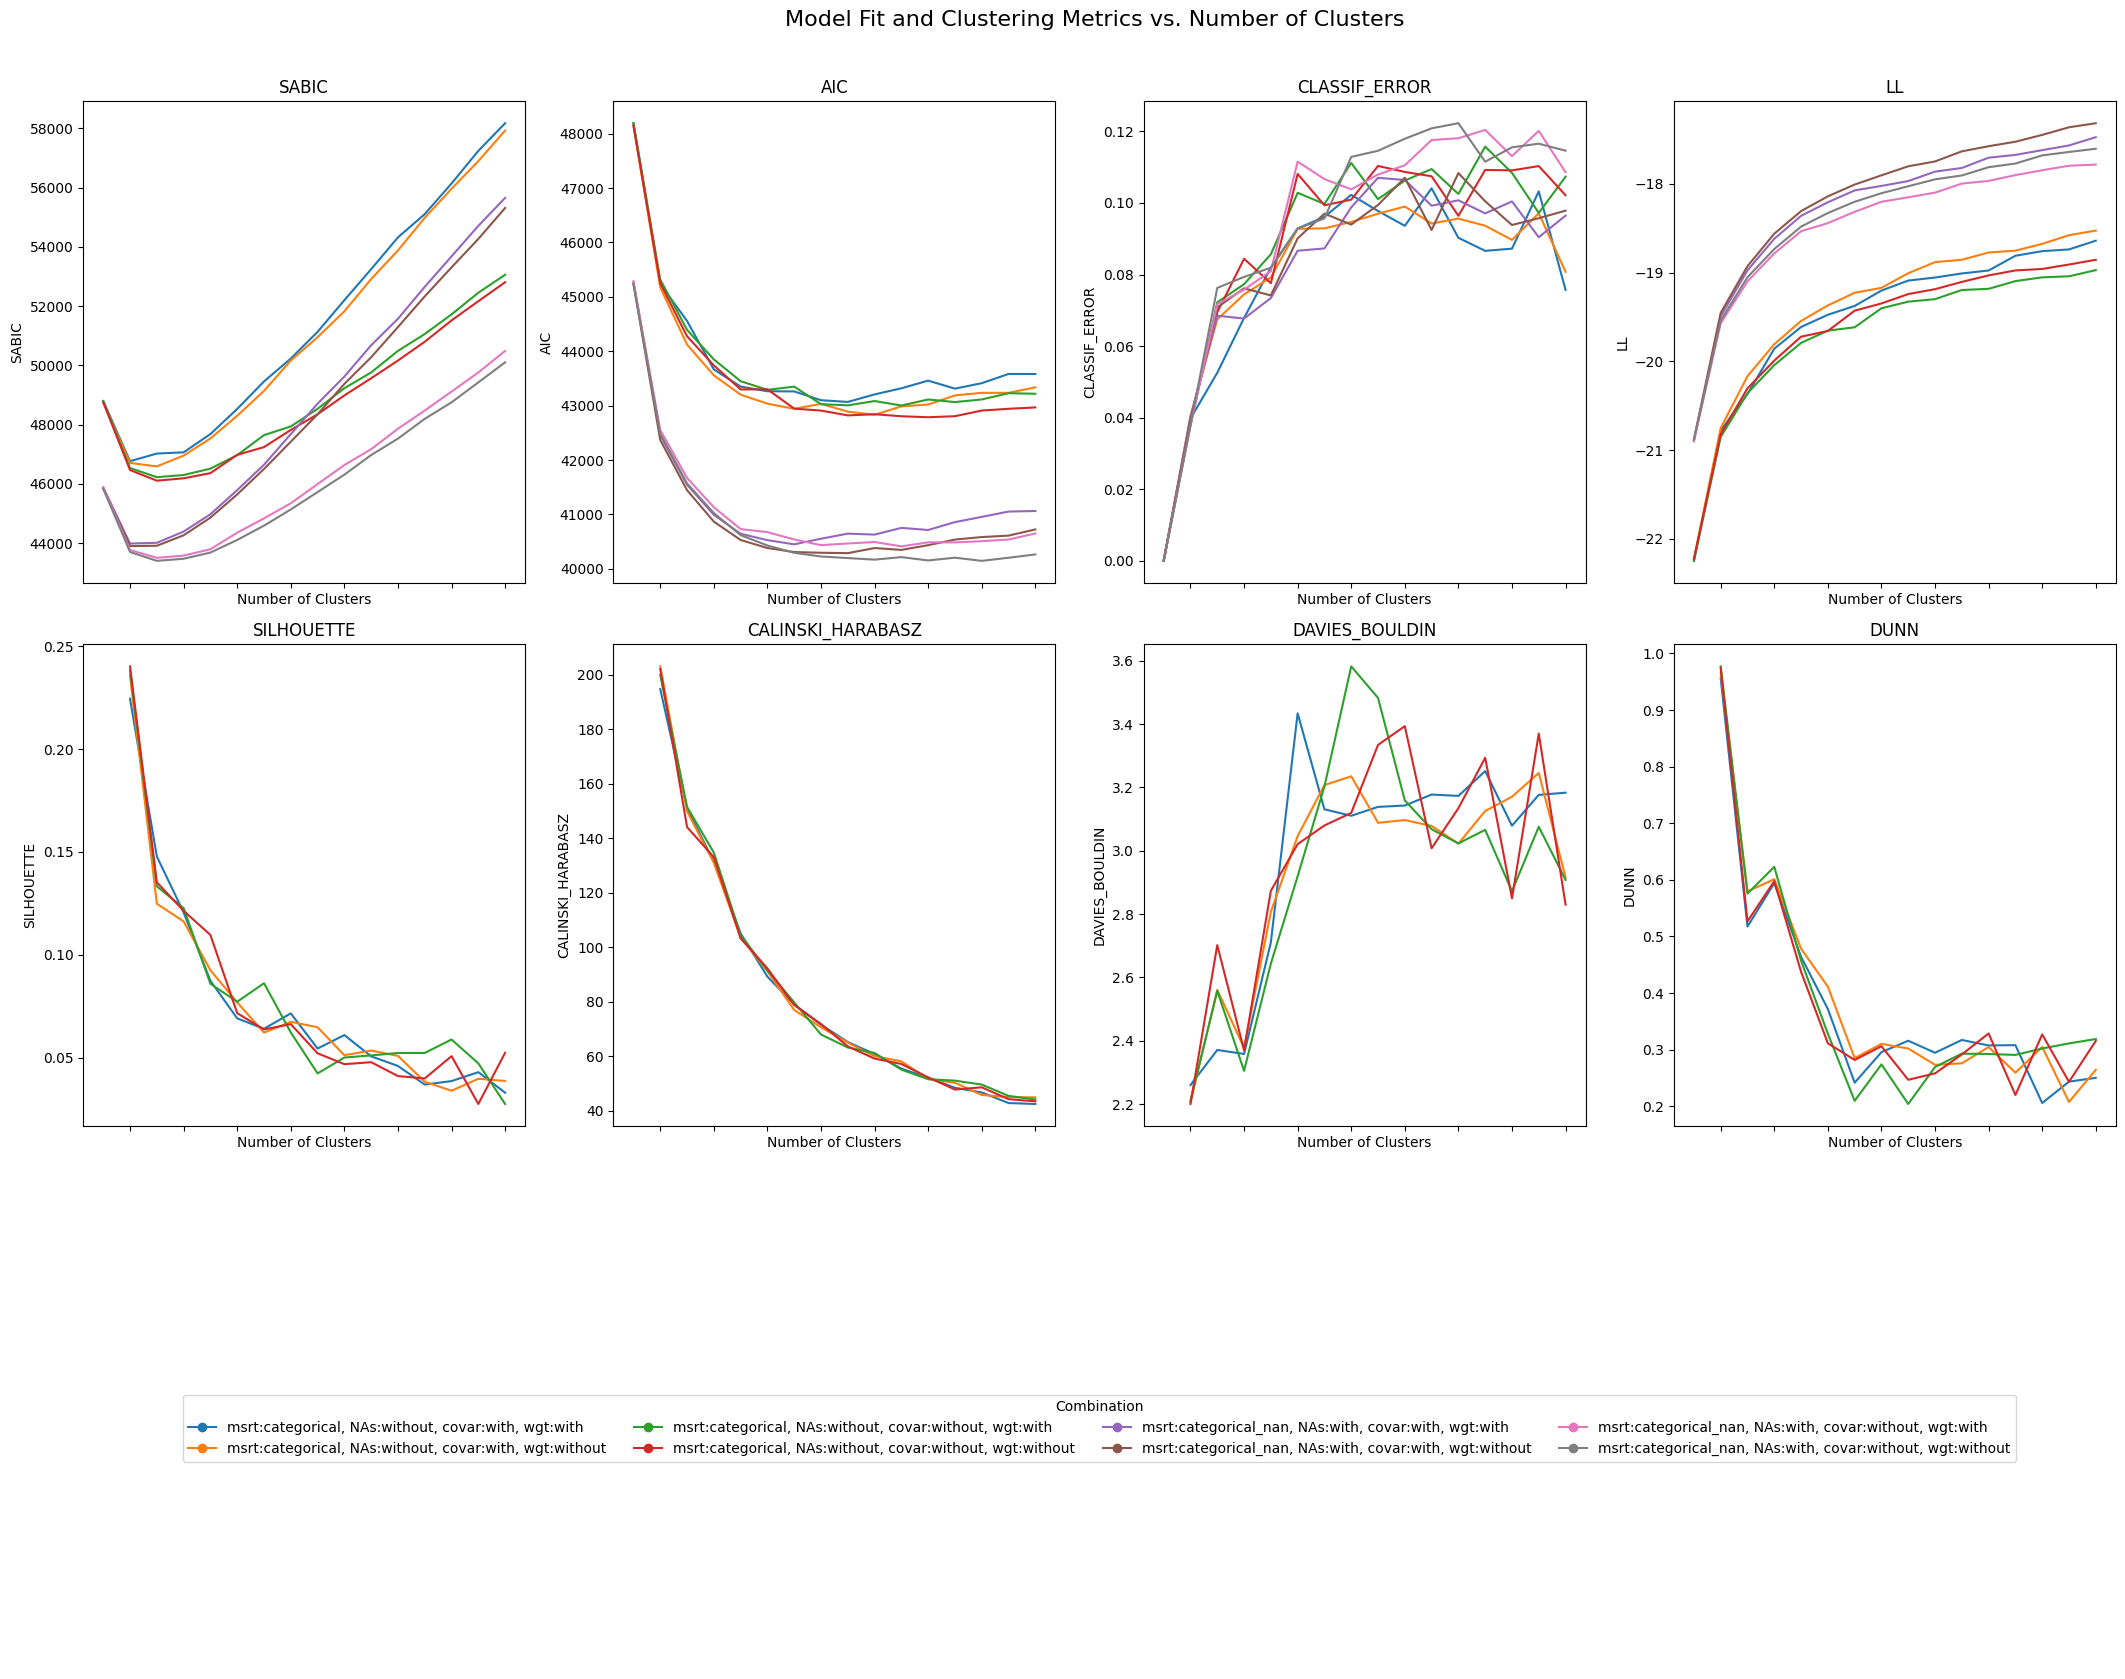

In [26]:
row1_metrics = ['sabic', 'aic', 'classif_error', 'LL']
row2_metrics = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
all_metrics = row1_metrics + row2_metrics

LCA.loc[:, 'label'] = LCA['params'].apply(extract_label)

# Create a 3-row x 4-column grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(22, 18), sharex=True)

axes = axes.flatten()

# Plot metrics in first 8 axes
for i, metric in enumerate(all_metrics):
    ax = axes[i]
    for label, group in LCA.groupby('label'):
        group = group.sort_values('n_clust')
        ax.plot(group['n_clust'], group[metric], marker='', label=label)
    ax.set_title(metric.upper())
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel(metric.upper())

# Hide any unused subplot (in case)
for j in range(8, 12):
    axes[j].axis('off')

# Legend in the entire third row (axes 8 to 11 merged)
# Remove the 4 axes in row 3 and create one big axis there:
for ax in axes[8:12]:
    fig.delaxes(ax)
legend_ax = fig.add_subplot(3,1,3)  # new axis spanning entire bottom row

legend_ax.axis('off')  # no axis lines or ticks

# Create dummy lines for legend from any group (using first group)
first_label = next(iter(LCA['label'].unique()))
lines = []
labels = []

for label, group in LCA.groupby('label'):
    line, = legend_ax.plot([], [], marker='o', label=label)
    lines.append(line)
    labels.append(label)

legend_ax.legend(lines, labels, loc='center', ncol=4, title="Combination")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.suptitle("Model Fit and Clustering Metrics vs. Number of Clusters", fontsize=16, y=0.98)

plt.show()

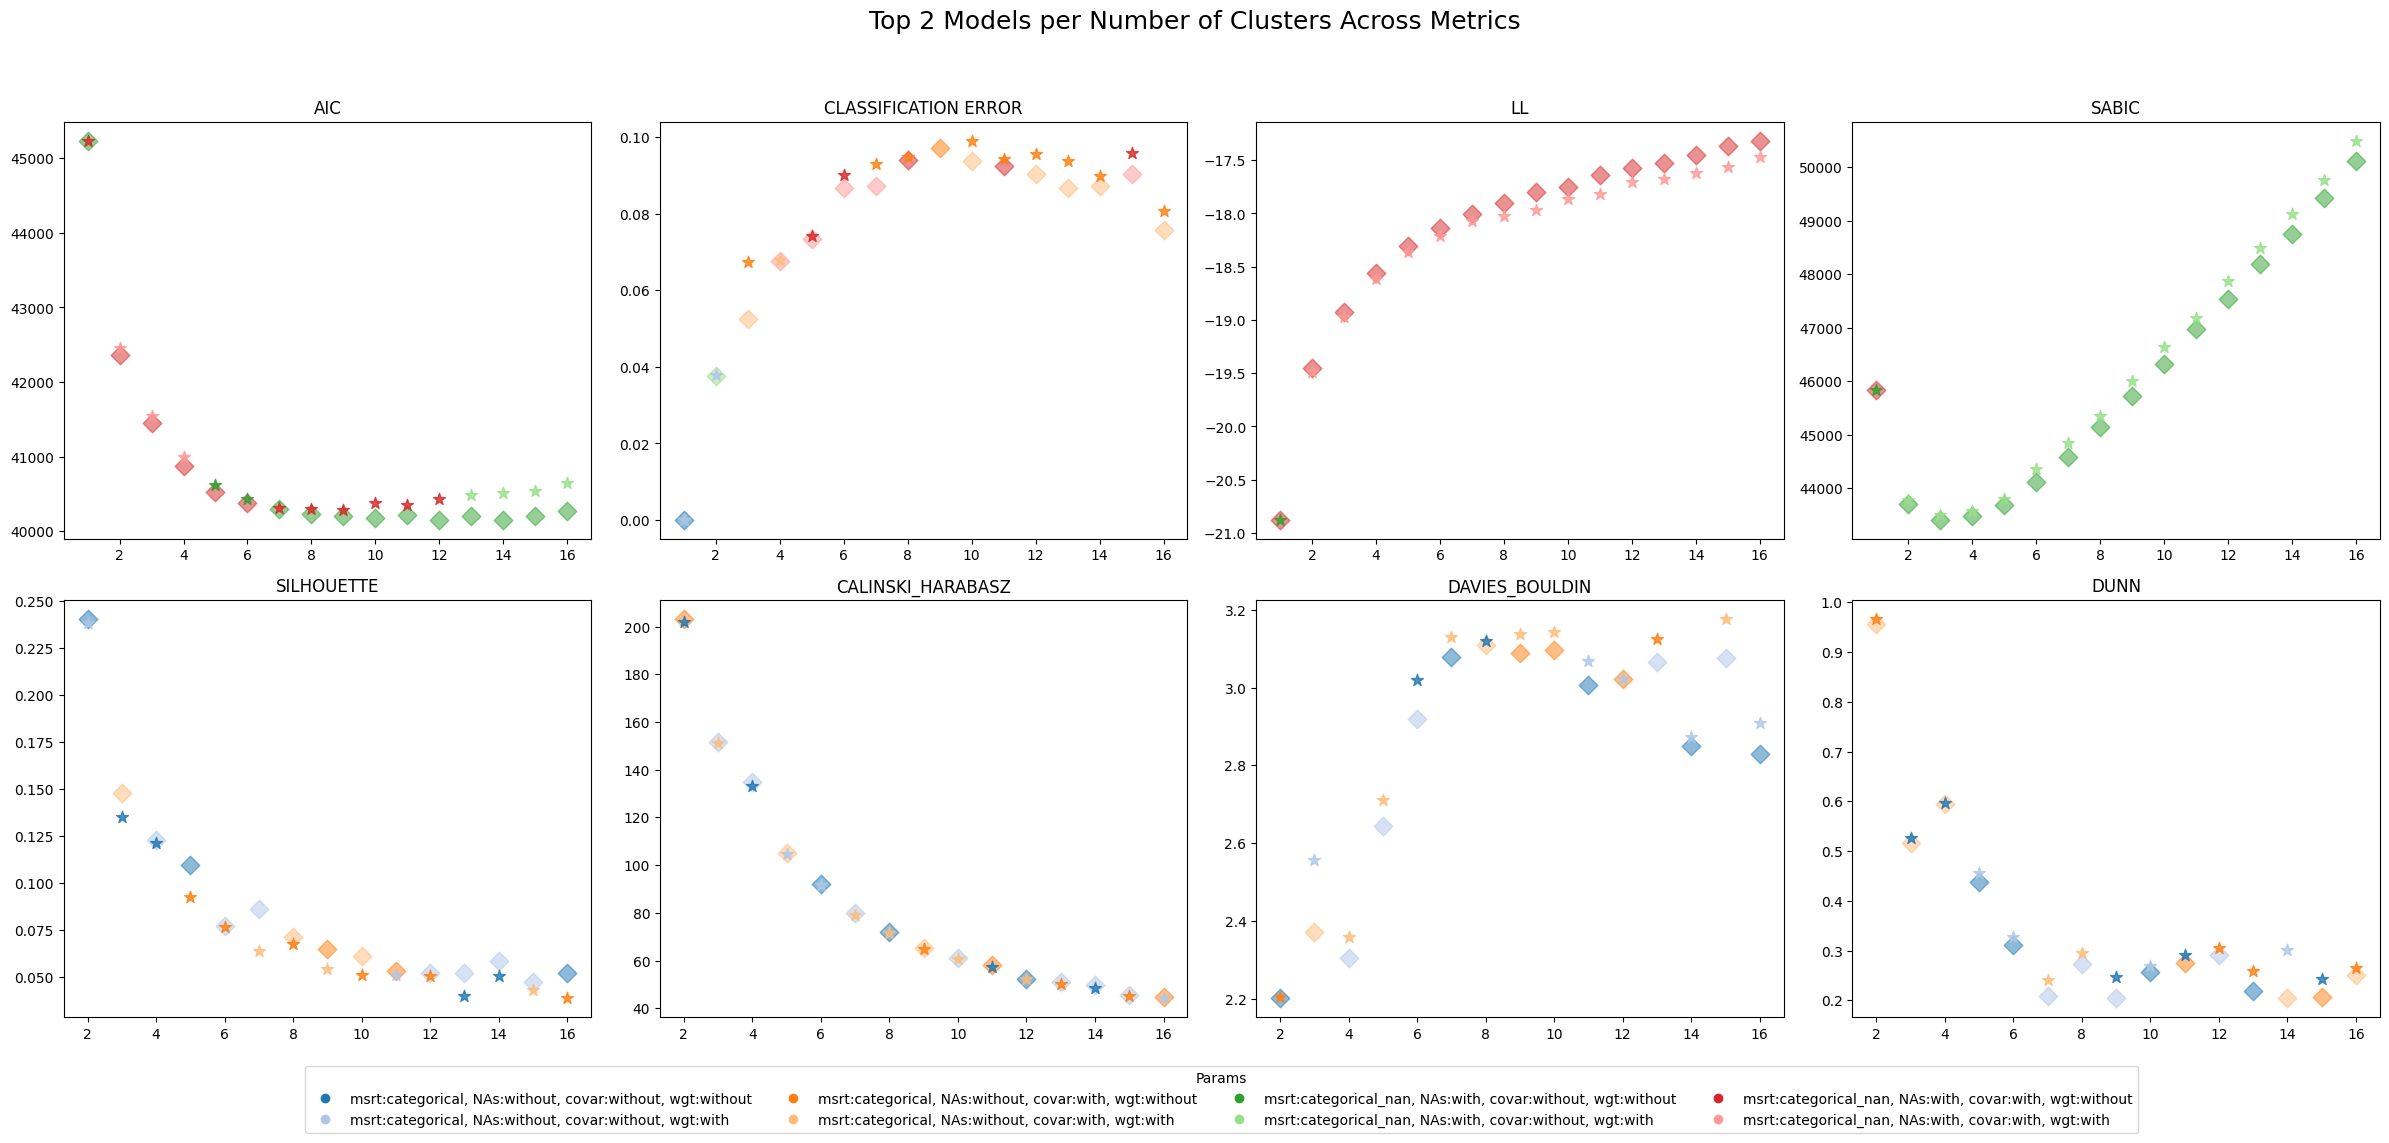

In [28]:
# Define your metric groups
metrics_row1 = ['aic', 'classif_error', 'LL', 'sabic']
metrics_row2 = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
all_metrics = metrics_row1 + metrics_row2

maximize_metrics = {'LL', 'silhouette', 'calinski_harabasz'}
marker_styles = ['D', '*']  # diamond = best, star = 2nd best
marker_alpha = [0.5, 0.8]
marker_size = [90, 80]
LCA.loc[:, 'label'] = LCA['params'].apply(extract_label)
unique_labels = LCA['label'].unique()
colors = {label: plt.cm.tab20(i % 20) for i, label in enumerate(unique_labels)}

# Set up GridSpec with 3 rows: 2 for plots, 1 for legend
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.1])  # last row is for legend

axes = [fig.add_subplot(gs[i // 4, i % 4]) for i in range(8)]

for i, metric in enumerate(all_metrics):
    ax = axes[i]
    maximize = metric in maximize_metrics

    df_metric = LCA.dropna(subset=[metric])

    sorted_df = (
        df_metric
        .sort_values(metric, ascending=not maximize)
        .groupby("n_clust")
        .head(2)
        .copy()
    )
    sorted_df['rank'] = sorted_df.groupby('n_clust').cumcount()

    for _, row in sorted_df.iterrows():
        marker = marker_styles[row['rank']]
        alpha = marker_alpha[row['rank']]
        size = marker_size[row['rank']]
        ax.scatter(
            row['n_clust'], row[metric],
            color=colors[row['label']],
            marker=marker,
            alpha=alpha,
            s=size,
            label=row['label'] if row['rank'] == 0 else None
        )

    title = "Classification error" if metric == 'classif_error' else metric
    ax.set_title(title.upper())
    # ax.set_xlabel("Number of Clusters")
    # ax.set_ylabel(metric.upper())
    ax.set_ylabel("")

# Create an extra subplot just for the legend
legend_ax = fig.add_subplot(gs[2, :])  # full width on third row
legend_ax.axis('off')

legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None',
               color=colors[label], label=label)
    for label in unique_labels
]
legend_ax.legend(handles=legend_handles, loc='center', ncol=4, title="Params", fontsize='medium')

plt.suptitle("Top 2 Models per Number of Clusters Across Metrics", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## LPA

/var/folders/39/44r9ct3n4hj3sdf26gj5wgp40000gn/T/ipykernel_39210/1961891217.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LPA.loc[:, 'label'] = LPA['params'].apply(extract_label)


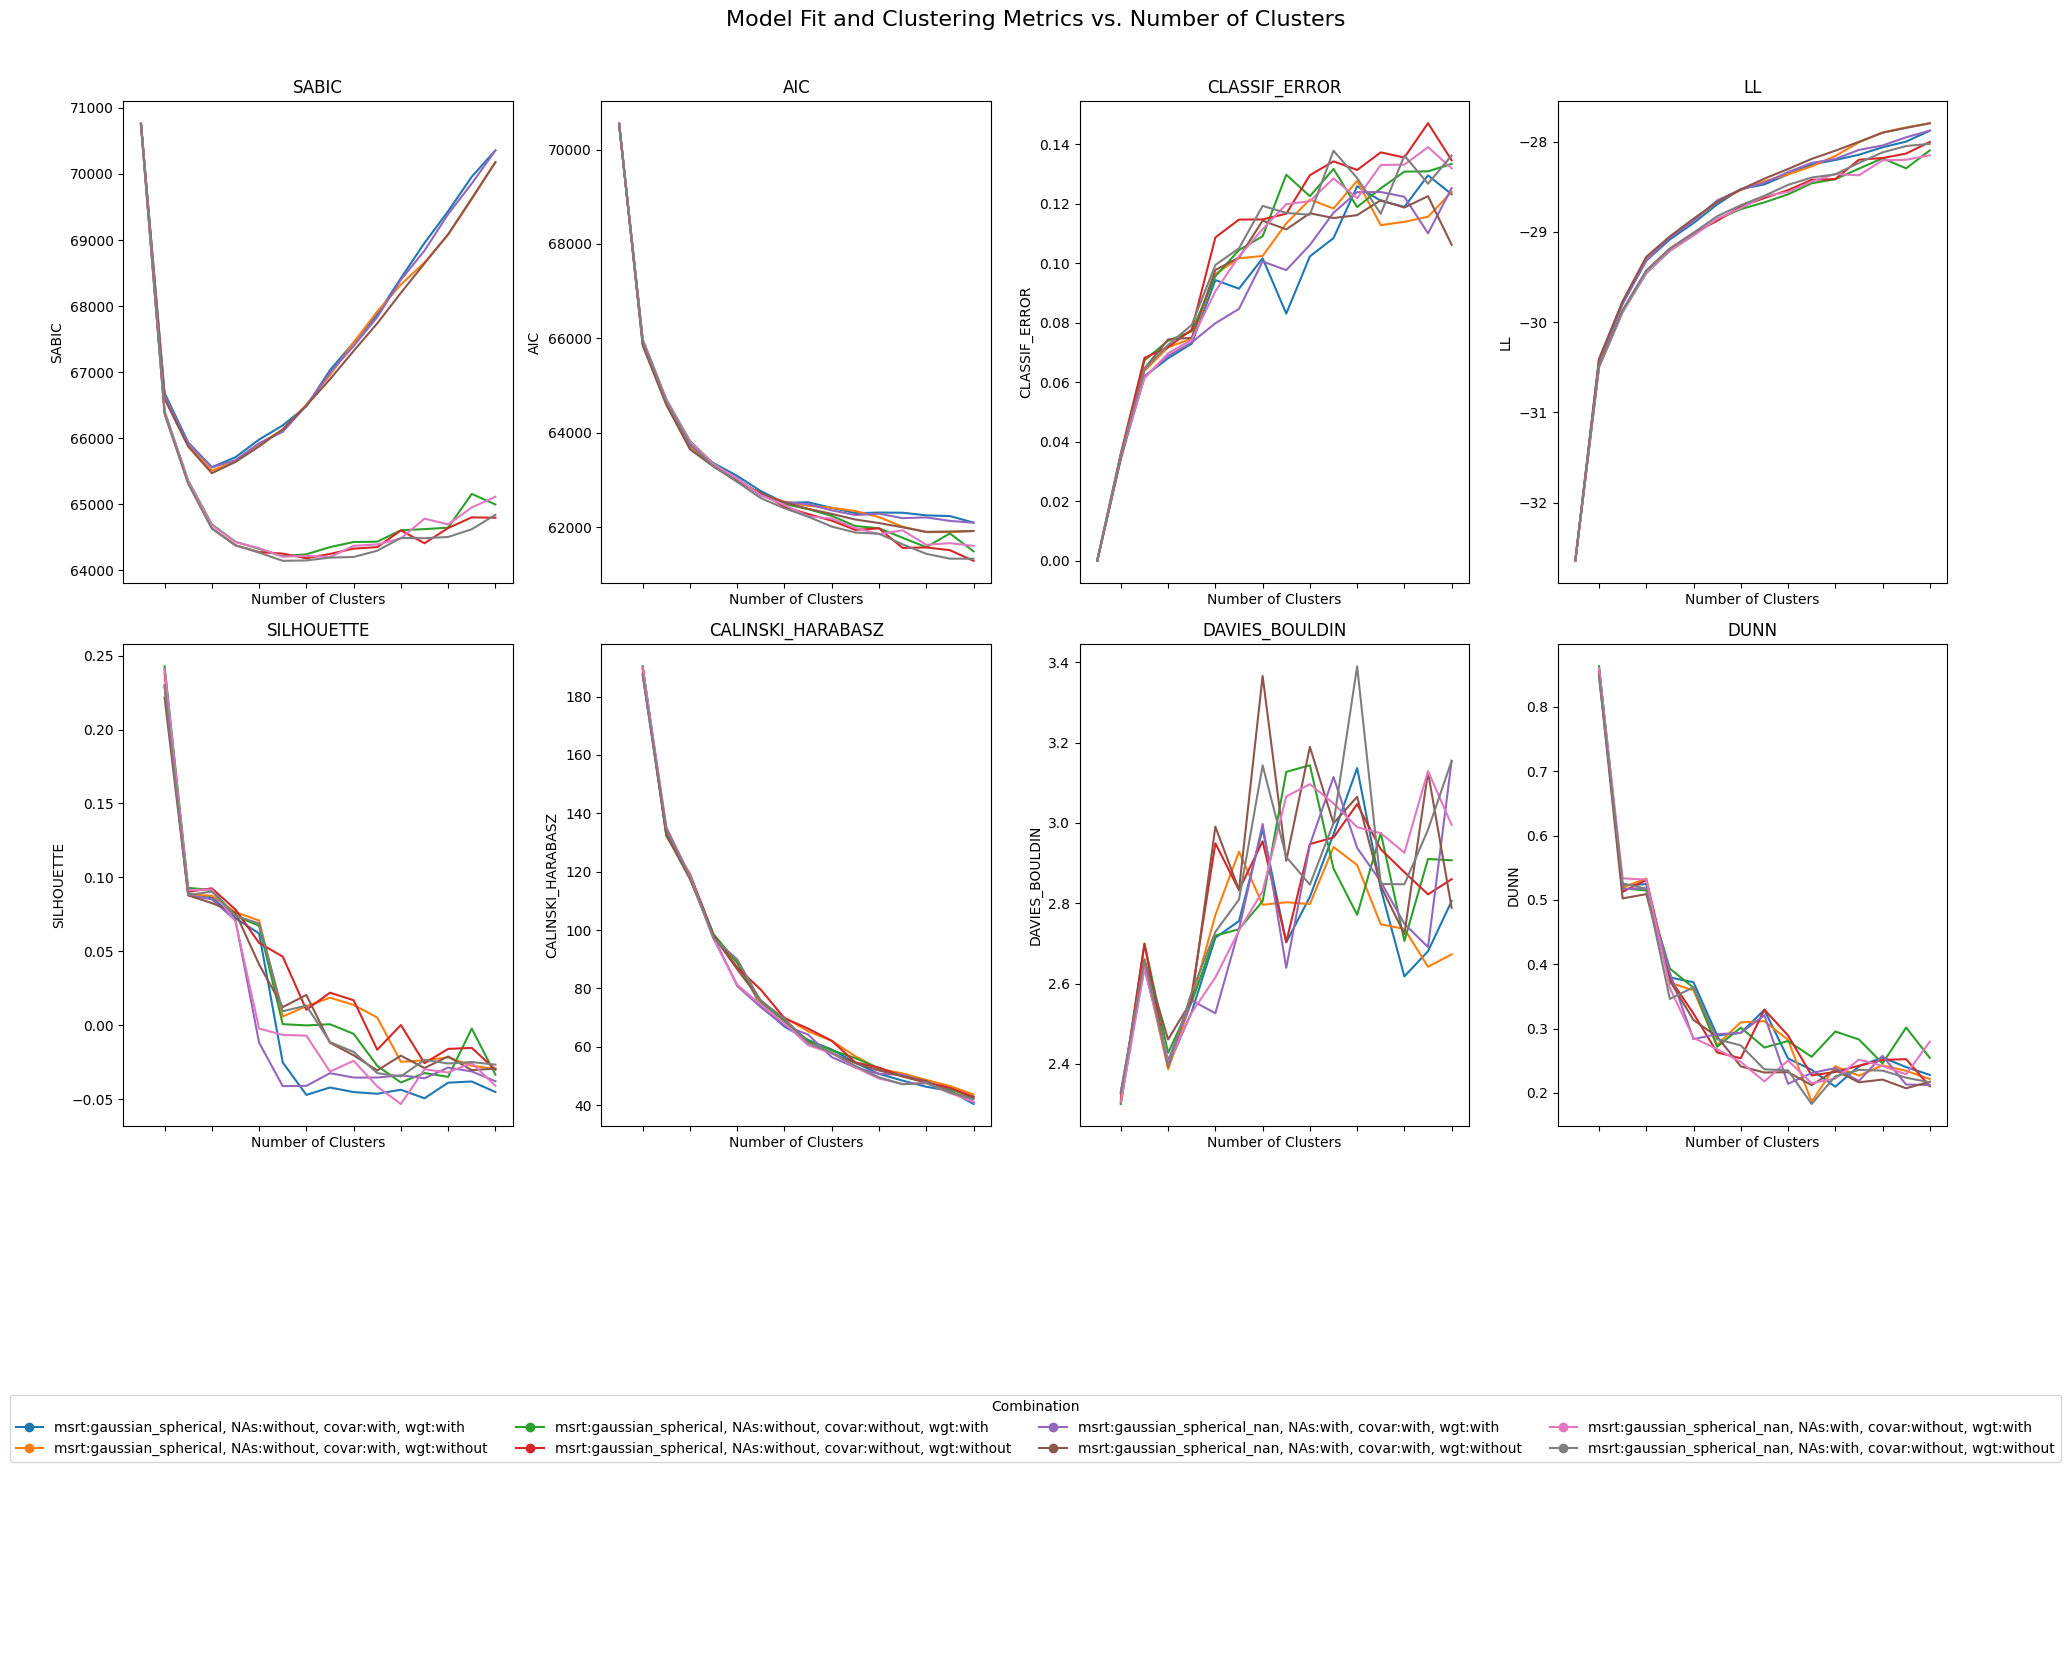

In [29]:
row1_metrics = ['sabic', 'aic', 'classif_error', 'LL']
row2_metrics = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
all_metrics = row1_metrics + row2_metrics

LPA.loc[:, 'label'] = LPA['params'].apply(extract_label)

# Create a 3-row x 4-column grid
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(22, 18), sharex=True)

axes = axes.flatten()

# Plot metrics in first 8 axes
for i, metric in enumerate(all_metrics):
    ax = axes[i]
    for label, group in LPA.groupby('label'):
        group = group.sort_values('n_clust')
        ax.plot(group['n_clust'], group[metric], marker='', label=label)
    ax.set_title(metric.upper())
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel(metric.upper())

# Hide any unused subplot (in case)
for j in range(8, 12):
    axes[j].axis('off')

# Legend in the entire third row (axes 8 to 11 merged)
# Remove the 4 axes in row 3 and create one big axis there:
for ax in axes[8:12]:
    fig.delaxes(ax)
legend_ax = fig.add_subplot(3,1,3)  # new axis spanning entire bottom row

legend_ax.axis('off')  # no axis lines or ticks

# Create dummy lines for legend from any group (using first group)
first_label = next(iter(LPA['label'].unique()))
lines = []
labels = []

for label, group in LPA.groupby('label'):
    line, = legend_ax.plot([], [], marker='o', label=label)
    lines.append(line)
    labels.append(label)

legend_ax.legend(lines, labels, loc='center', ncol=4, title="Combination")

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.suptitle("Model Fit and Clustering Metrics vs. Number of Clusters", fontsize=16, y=0.98)

plt.show()

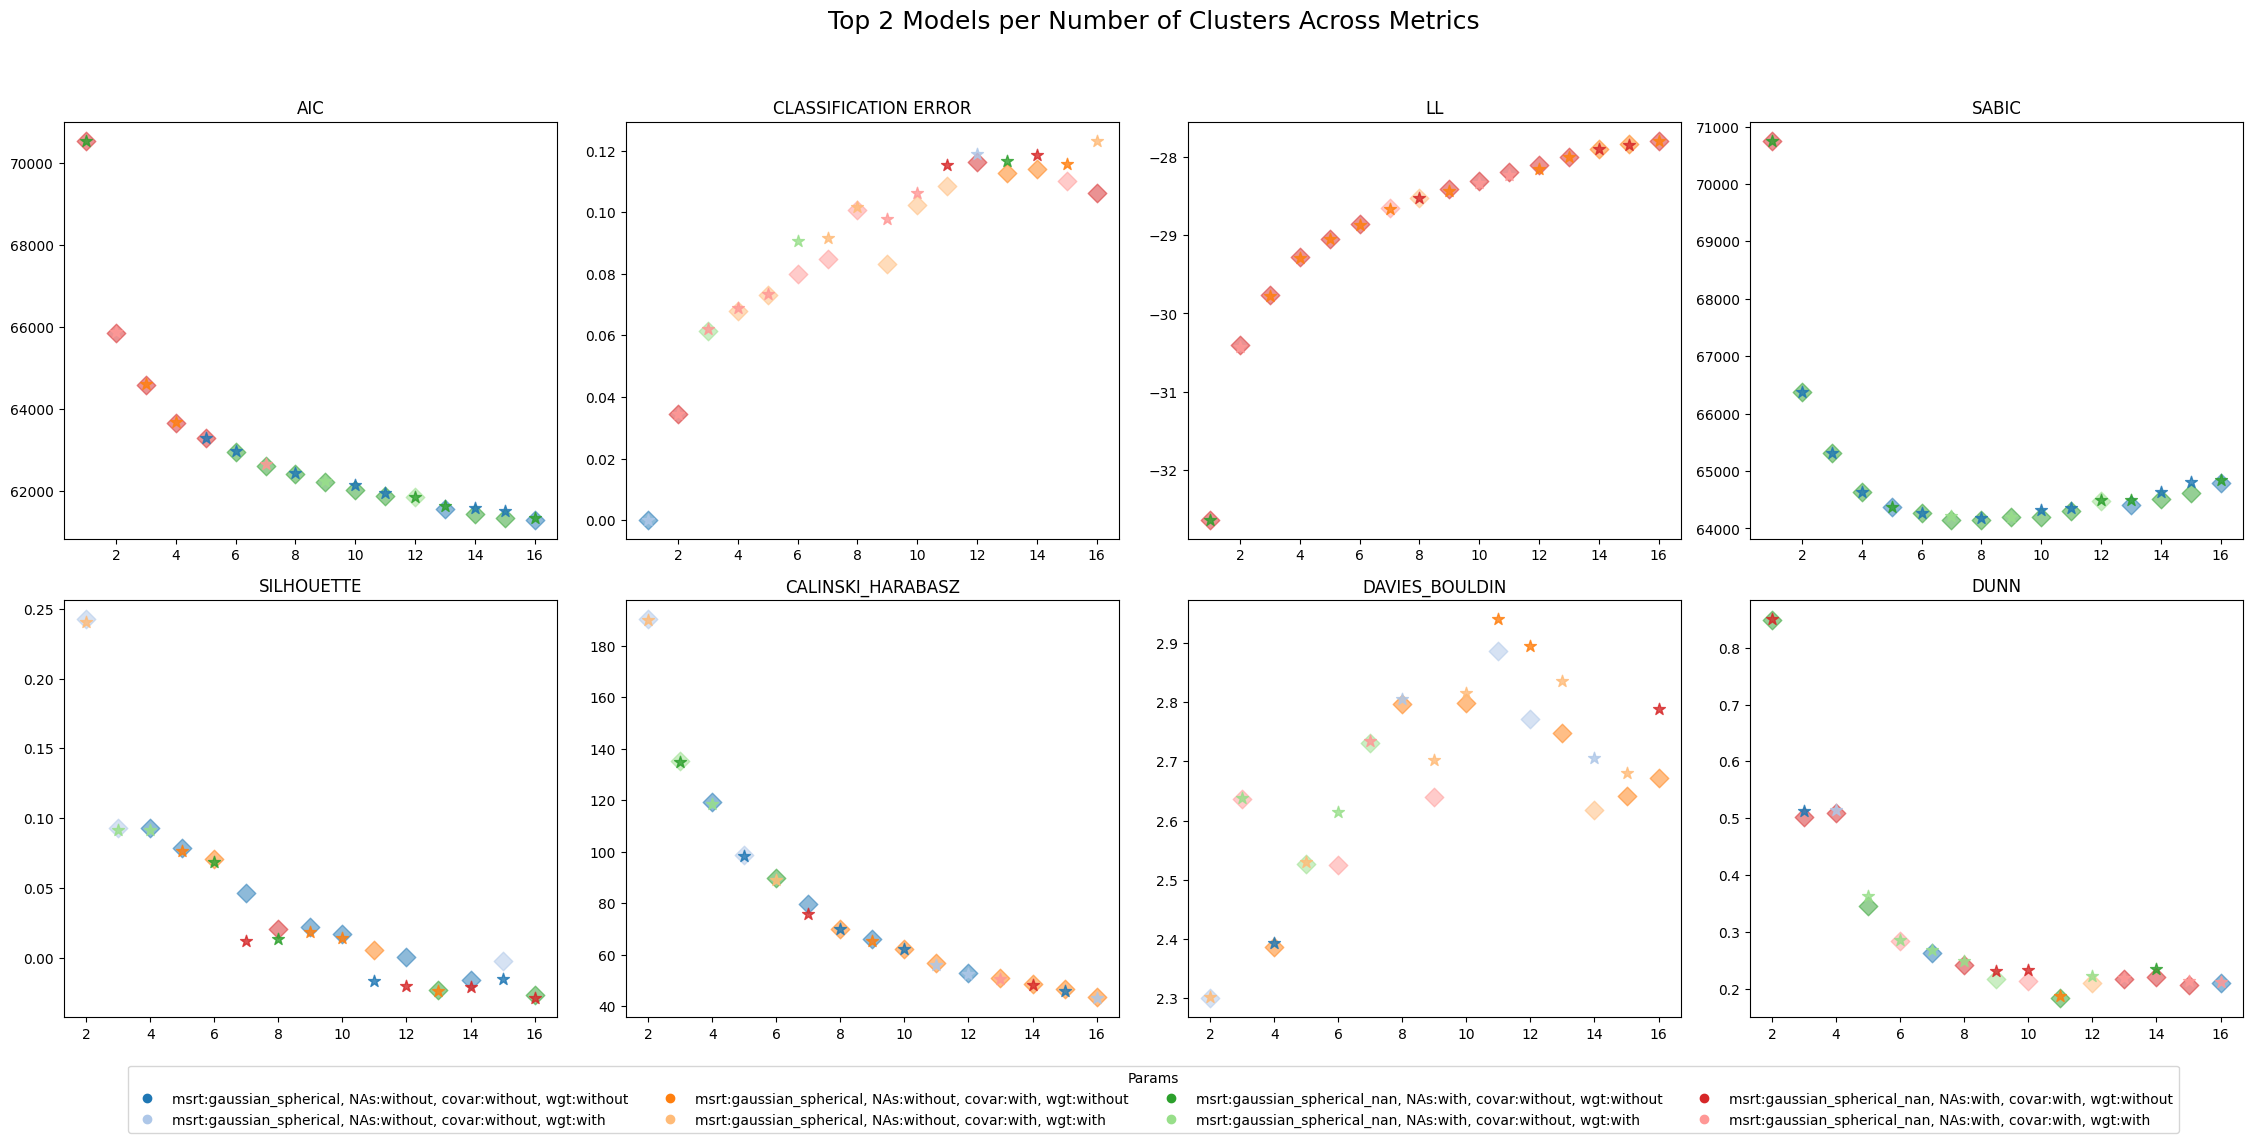

In [30]:
# Define your metric groups
metrics_row1 = ['aic', 'classif_error', 'LL', 'sabic']
metrics_row2 = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'dunn']
all_metrics = metrics_row1 + metrics_row2

maximize_metrics = {'LL', 'silhouette', 'calinski_harabasz'}
marker_styles = ['D', '*']  # diamond = best, star = 2nd best
marker_alpha = [0.5, 0.8]
marker_size = [90, 80]
LPA.loc[:, 'label'] = LPA['params'].apply(extract_label)
unique_labels = LPA['label'].unique()
colors = {label: plt.cm.tab20(i % 20) for i, label in enumerate(unique_labels)}

# Set up GridSpec with 3 rows: 2 for plots, 1 for legend
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(3, 4, height_ratios=[1, 1, 0.1])  # last row is for legend

axes = [fig.add_subplot(gs[i // 4, i % 4]) for i in range(8)]

for i, metric in enumerate(all_metrics):
    ax = axes[i]
    maximize = metric in maximize_metrics

    df_metric = LPA.dropna(subset=[metric])

    sorted_df = (
        df_metric
        .sort_values(metric, ascending=not maximize)
        .groupby("n_clust")
        .head(2)
        .copy()
    )
    sorted_df['rank'] = sorted_df.groupby('n_clust').cumcount()

    for _, row in sorted_df.iterrows():
        marker = marker_styles[row['rank']]
        alpha = marker_alpha[row['rank']]
        size = marker_size[row['rank']]
        ax.scatter(
            row['n_clust'], row[metric],
            color=colors[row['label']],
            marker=marker,
            alpha=alpha,
            s=size,
            label=row['label'] if row['rank'] == 0 else None
        )

    title = "Classification error" if metric == 'classif_error' else metric
    ax.set_title(title.upper())
    # ax.set_xlabel("Number of Clusters")
    # ax.set_ylabel(metric.upper())
    ax.set_ylabel("")

# Create an extra subplot just for the legend
legend_ax = fig.add_subplot(gs[2, :])  # full width on third row
legend_ax.axis('off')

legend_handles = [
    plt.Line2D([0], [0], marker='o', linestyle='None',
               color=colors[label], label=label)
    for label in unique_labels
]
legend_ax.legend(handles=legend_handles, loc='center', ncol=4, title="Params", fontsize='medium')

plt.suptitle("Top 2 Models per Number of Clusters Across Metrics", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()